<a href="https://colab.research.google.com/github/RoyEdri/Medical-Data-Analysis-MIMIC-III/blob/main/Project__1__MIMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project #1 Detecting Patterns in Tabular Medical Data with MIMIC-III
You can read more about the dataset here: https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction

Dr. Barak Or

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
my_path="/content/drive/MyDrive/project 1/"

In [69]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Load the data
data = pd.read_csv(my_path+"MIMIC_data.csv")

In [70]:
print(data.head())

   group      ID  outcome  age  gendera        BMI  hypertensive  \
0      1  125047      0.0   72        1  37.588179             0   
1      1  139812      0.0   75        2        NaN             0   
2      1  109787      0.0   83        2  26.572634             0   
3      1  130587      0.0   43        2  83.264629             0   
4      1  138290      0.0   75        2  31.824842             1   

   atrialfibrillation  CHD with no MI  diabetes  ...  Blood sodium  \
0                   0               0         1  ...    138.750000   
1                   0               0         0  ...    138.888889   
2                   0               0         0  ...    140.714286   
3                   0               0         0  ...    138.500000   
4                   0               0         0  ...    136.666667   

   Blood calcium    Chloride  Anion gap  Magnesium ion     PH  Bicarbonate  \
0       7.463636  109.166667  13.166667       2.618182  7.230    21.166667   
1       8.1625

# Q1.a
What are the mean, median, mode, and standard deviation of the age, BMI, and Blood sodium columns in the dataset? Why are these statistics important for understanding the data?

In [71]:
def statistics(feature_name):
  print(f'{feature_name}:')
  print(f'The mean is: {data[feature_name].mean():.2f}')
  print(f'The median is: {data[feature_name].median():.2f}')
  print(f'The mode is: {stats.mode(data[feature_name])[0]:.2f}')
  print(f'The deviation is: {data[feature_name].std():.2f}\n')

statistics('age')
statistics('BMI')
statistics('Blood sodium')

age:
The mean is: 74.06
The median is: 77.00
The mode is: 89.00
The deviation is: 13.43

BMI:
The mean is: 30.19
The median is: 28.31
The mode is: nan
The deviation is: 9.33

Blood sodium:
The mean is: 138.89
The median is: 139.25
The mode is: 140.00
The deviation is: 4.15



###Why are these statistics important for understanding the data###
Mean, median, and mode help identify the central value of the data,
Standard deviation will shows how much the data varies.
In addition to this these statistics provide a comprehensive view for making informed decisions.
These statistics together give a clear understanding of the characteristics and patterns in the data.

# Q1.b
How do the distributions of age, BMI, and Blood sodium look in the dataset? What can we learn from these distributions about the patient population?

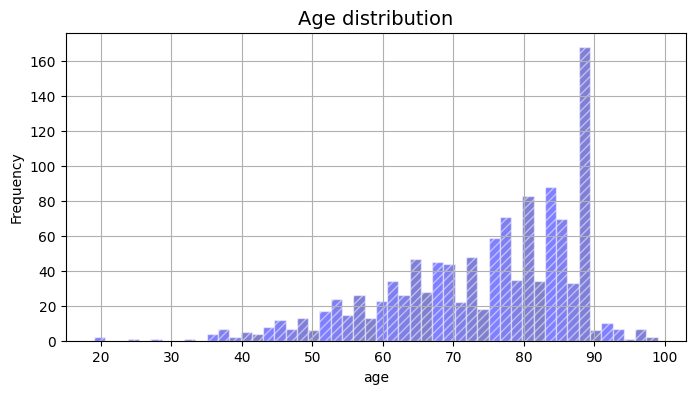

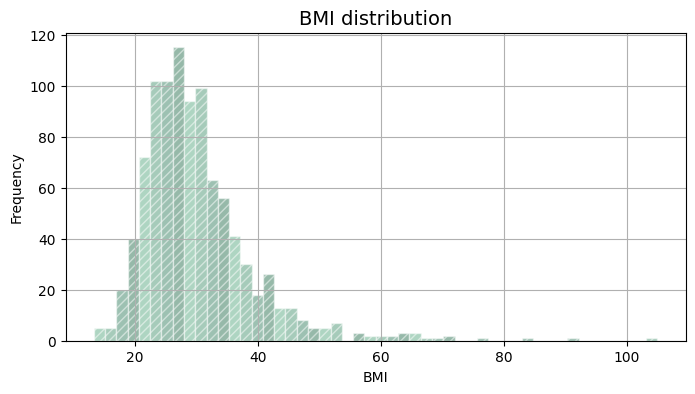

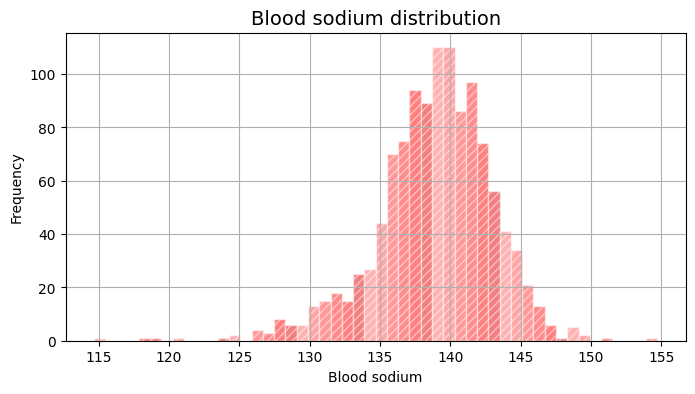

In [72]:
def colors_set(patches,colors):
  hatches = ['////']
  for i in range(len(patches)):
    patches[i].set_facecolor(colors[i % len(colors)])
    patches[i].set_hatch(hatches[i % len(hatches)])
  return patches

def distributions(feature_name, colors,title):
  plt.figure(figsize=(8, 4))
  n, bins, patches = plt.hist(data[feature_name], bins=50, edgecolor = 'white',alpha = 0.5, color = 'white')
  colors_set(patches,colors)
  plt.title(title, fontsize = 14)
  plt.xlabel(feature_name)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

# Age distribution:
colors = ["#0000FF", "#0000E5", "#0000CC", "#0000B2", "#000099"]
distributions('age',colors,'Age distribution')

# BMI distribution:
colors = [ '#5FAD87', '#4F9877', '#3D8567', '#2F7454']
distributions('BMI',colors,'BMI distribution')

# Blood sodium distribution:
colors = ['#FF6666', '#FF4C4C', '#FF3333', '#FF1919', '#FF0000', '#E50000']
distributions('Blood sodium',colors,'Blood sodium distribution')

# Q 1.c
Use pandas and scikit-learn to drop rows with missing values in the 'BMI' and 'Blood sodium'
columns, and then uses logistic regression, SVM, kNN, and decision tree to predict an
'outcome' based on the features 'age', 'BMI', and 'blood sodium'. Ensure to split the data
using train_test_split with a 20% test size and a random state of 42. Finally, fit the model,
make predictions on the test set, and print a report of the best model
(“classification_report”). Explain the result of the confusion matrix for the best model
where you mention for each cell its meaning.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [74]:
# Drop rows with missing values in the 'BMI' and 'Blood sodium' columns
data.dropna(subset=['BMI', 'Blood sodium'], inplace=True)

# Extract features ('age', 'BMI', 'Blood sodium') and target ('outcome')
features = ['age', 'BMI', 'Blood sodium']
X = data[features]
y = data['outcome']

# Splitting the dataset into training and testing sets with a random state of 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
def _add_confusion_matrix_plot(cf_matrix):
    """
    A utility function to add a confusion matrix plot
    """
    group_names = ["TN","FP","FN","TP"]
    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{name}\n{count}\n{percentage}"
              for name, count, percentage
              in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

# Method to plot confusion matrix
def plot_confusion_matrix(y_pred, title, y_test):
    """
    Plots the confusion matrix with provided predictions and title
    """
    plt.figure(figsize=(5, 5))
    _add_confusion_matrix_plot(confusion_matrix(y_test, y_pred))
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()
    print("\n")

In [76]:
# Function to evaluate the model and store the results in a dictionary
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test, results):
    """
    Evaluates the model, stores results in a dictionary, and returns predictions
    """
    # Predict on training data
    train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f'Train Accuracy for {model_name}: {train_accuracy}')

    # Predict on testing data
    test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f'Test Accuracy for {model_name}: {test_accuracy}\n')

    # Store results in the dictionary
    results[model_name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'classification_report': classification_report(y_test, test_pred, output_dict=True, zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, test_pred)
    }
    return test_pred

# Dictionary to store the results
results = {}
models = {}

Decision Tree:
Train Accuracy for Decision Tree: 1.0
Test Accuracy for Decision Tree: 0.7927461139896373



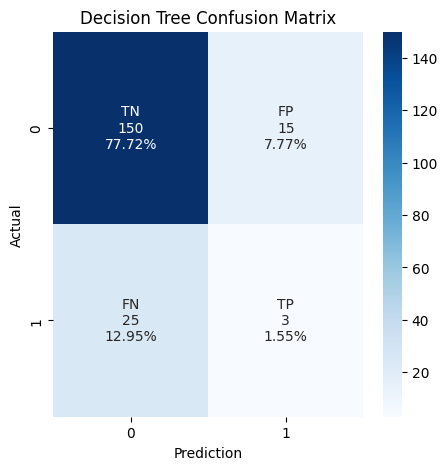

In [77]:
######################   Decision Tree   ######################
print("Decision Tree:")
dt_model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
dt_y_pred = evaluate_model(dt_model, 'Decision Tree', X_train, X_test, y_train, y_test, results)
models['decision tree'] = dt_model
plot_confusion_matrix(dt_y_pred, "Decision Tree Confusion Matrix", y_test)

## **Decision Tree Model**
###**The confusion matrix for the Decision Tree model indicates the following performance metrics:**

###**True Negative Rate: 77.72%**
The model correctly identified 77.72% of the negative instances.
###**False Negative Rate: 12.95%**
The model misclassified 12.95% of the positive instances as negative.
###**True Positive Rate: 1.55%**
The model correctly identified 1.55% of the positive instances.
###**False Positive Rate: 7.77%**
The model misclassified 7.77% of the negative instances as positive.

**The performance of the Decision Tree model reveals interesting insights about the importance of confusion matrices. Although its overall accuracy is lower than that of some other models, its ability to correctly identify positive instances (True Positives) makes it more valuable in this context. Given that correctly predicting the 'Dead' class (class 1.0) is more critical than overall accuracy, and considering the imbalanced nature of the dataset, the Decision Tree model stands out as the best option among all the suboptimal models evaluated.**

kNN:
Train Accuracy for kNN: 0.8855656697009102
Test Accuracy for kNN: 0.8393782383419689



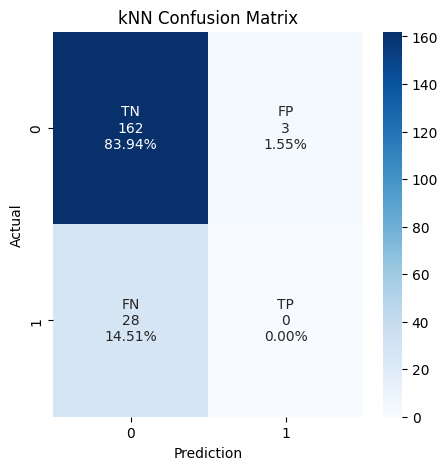

In [78]:
##########################   kNN    ###########################
print("kNN:")
knn_model = KNeighborsClassifier().fit(X_train, y_train)
knn_y_pred = evaluate_model(knn_model, 'kNN', X_train, X_test, y_train, y_test, results)
models['knn'] = knn_model
plot_confusion_matrix(knn_y_pred, "kNN Confusion Matrix", y_test)

##**kNN Model**
###**The confusion matrix for the kNN model indicates the following performance metrics:**
###**True Negative Rate: 83.94%**
The model correctly identified 83.94% of the negative instances.

###**False Negative Rate: 14.51%**
The model misclassified 14.51% of the positive instances as negative.

###**True Positive Rate: 0%**
The model failed to identify any positive instances.

###**False Positive Rate: 1.55%**
The model misclassified 1.55% of the negative instances as positive.


**The performance of the kNN model reveals significant issues in its ability to identify positive instances. Worse than Logistic Regression and SVC, it also incorrectly predicted 1.55% of negative instances as positive. This makes kNN unsuitable for applications where identifying the positive class is crucial. Thus, substantial improvements or alternative modeling approaches are necessary to achieve balanced and accurate classification performance.**

Support Vector Machine (Classifier):
Train Accuracy for SVM: 0.8881664499349805
Test Accuracy for SVM: 0.8549222797927462



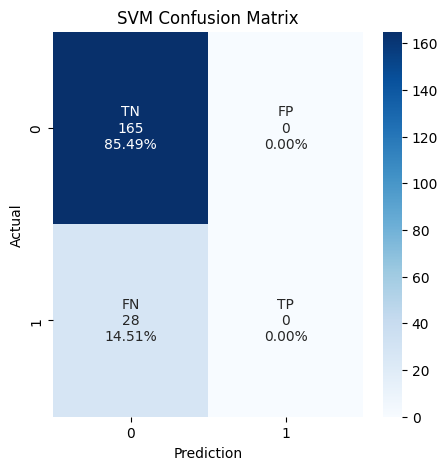

In [79]:
##########################   SVM    ###########################
print("Support Vector Machine (Classifier):")
svm_model = SVC(random_state=42).fit(X_train, y_train)
svm_y_pred = evaluate_model(svm_model, 'SVM', X_train, X_test, y_train, y_test, results)
models['svm'] = svm_model
plot_confusion_matrix(svm_y_pred, "SVM Confusion Matrix", y_test)

## **SVM Model (The Best Model)**
### **The confusion matrix for the SVM model indicates the following performance metrics:**
### **True Negative Rate: 85.49%**
The model correctly identified 85.49% of the negative instances.

### **False Negative Rate: 14.51%**
The model misclassified 14.51% of the positive instances as negative.

### **True Positive Rate: 0%**
The model failed to identify any positive instances.

### **False Positive Rate: 0%**
The model did not misclassify any negative instances as positive.

**The SVM model's performance is equivalent to that of Logistic Regression, showing no difference in its acceptance or relevance. The inability to identify any positive instances makes it ineffective for tasks requiring accurate prediction of the positive class. However, given its overall accuracy and the imbalanced nature of the dataset, it was still considered the best among the evaluated models due to the metrics shown in the classification report.**

Logistic Regression:
Train Accuracy for Logistic Regression: 0.8881664499349805
Test Accuracy for Logistic Regression: 0.8549222797927462



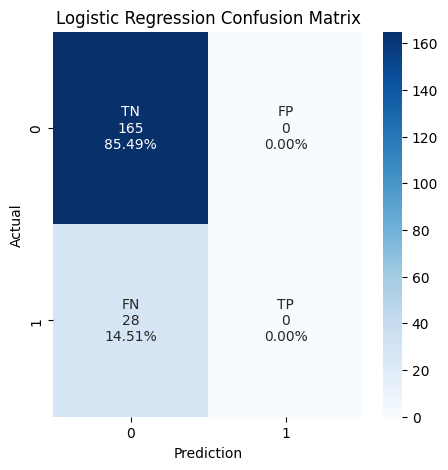

In [80]:
####################  Logistic Regression  ####################
print("Logistic Regression:")
lr_model = LogisticRegression(random_state=42).fit(X_train, y_train)
lr_y_pred = evaluate_model(lr_model, 'Logistic Regression', X_train, X_test, y_train, y_test, results)
models['logistic regression'] = lr_model
plot_confusion_matrix(lr_y_pred, "Logistic Regression Confusion Matrix", y_test)

##**Logistic Regression Model**
###**The confusion matrix for the Logistic Regression model indicates the following performance metrics:**
###**True Negative Rate: 85.49%**
The model correctly identified 85.49% of the negative instances.

###**False Negative Rate: 14.51%**
The model misclassified 14.51% of the positive instances as negative.

###**True Positive Rate: 0%**
The model failed to identify any positive instances.

###**False Positive Rate: 0%**
The model did not misclassify any negative instances as positive.

**The model's failure to identify any positive instances (True Positives) while perfectly avoiding False Positives indicates a strong bias towards the negative class, likely due to the imbalanced dataset. This results in a complete neglect of the 'Dead' class (class 1.0), which is highly problematic and unacceptable for any meaningful classification task.**

In [81]:
from sklearn.metrics import classification_report, f1_score

# Function to determine the best model based on test accuracy and F1-score as a tiebreaker
def best_model():
    """
    Determines the best model based on the highest test accuracy, with F1-score for the positive class as a tiebreaker.
    """
    best_test_accuracy = -1  # Initialize with a value that guarantees any model will be better
    best_f1_score = -1       # F1-score for tiebreaker
    best_model_name = None

    for model_name, model_results in results.items():
        test_accuracy = model_results['test_accuracy']
        # Calculate F1-score for the positive class
        f1 = model_results['classification_report']['1.0']['f1-score']

        if test_accuracy > best_test_accuracy or (test_accuracy == best_test_accuracy and f1 > best_f1_score):
            best_test_accuracy = test_accuracy
            best_f1_score = f1
            best_model_name = model_name

    # Print the classification report of the best model
    if best_model_name is not None:
        print(f"The Best model is: {best_model_name}")
        report = classification_report(y_test, models[best_model_name.lower()].predict(X_test), zero_division=0)
        print("Classification Report:")
        print(report)
    else:
        print("No suitable model was found.")

# Evaluate and determine the best model
best_model()


The Best model is: SVM
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       165
         1.0       0.00      0.00      0.00        28

    accuracy                           0.85       193
   macro avg       0.43      0.50      0.46       193
weighted avg       0.73      0.85      0.79       193



# Q1.d
Predict BMI based on age and Blood sodium with linear regression, SVM regressor, Decision tree regressor, and kNN refressor. Calculate RMSE, MSE, R-squared.
Split where 20% left for the test, random state=42.
Plot the actual vs. the predicted value for each model’s test
dataset.

In [82]:
# Droping the rows with missing values in the 'BMI' and 'Blood sodium' and 'Age'columns
data.dropna(subset = ['age', 'BMI', 'Blood sodium'], inplace = True)

# X:
# Extract features ('age', 'bmi', 'blood_sodium')
features = ['age', 'Blood sodium']
x = data[features]

# Y:
target = 'BMI'
y = data[target]

#  Split the data into training and testing sets, with 20% of the data reserved for the test set and the random state set to 42.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)


In [83]:
from sklearn.metrics import mean_squared_error, r2_score

result = {}
# printing the metrics dictionary
def calculate_metrics(model_name, y_pred, y):
    # MSE
    mse = mean_squared_error(y, y_pred)
    # RMSE
    rmse = np.sqrt(mse)
    # R^2 Score
    r2 = r2_score(y, y_pred)
    result[model_name] = {
            'MSE': mse,
            'RMSE': rmse,
            'R2-Score': r2
        }
    return mse, rmse, r2

def actual_vs_predicted_plot(ax, model_name, y_test, test_prediction,mse ,rmse,r2,color):
    ax.scatter(y_test, test_prediction, alpha=0.8, color=color)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
    ax.set_xlabel("Actual BMI", color = color,fontsize=12)
    ax.set_ylabel("Predicted BMI" , color = color,fontsize=12)
    ax.set_title(f"{model_name}", color=color, fontsize=16)
    ax.grid(True)
    # Add text with metrics objects above the plot
    ax.text(0.5, 1.15, f'MSE: {mse}\nRMSE: {rmse}\nR2-Score: {r2}', transform=ax.transAxes,
            ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8),color = color)



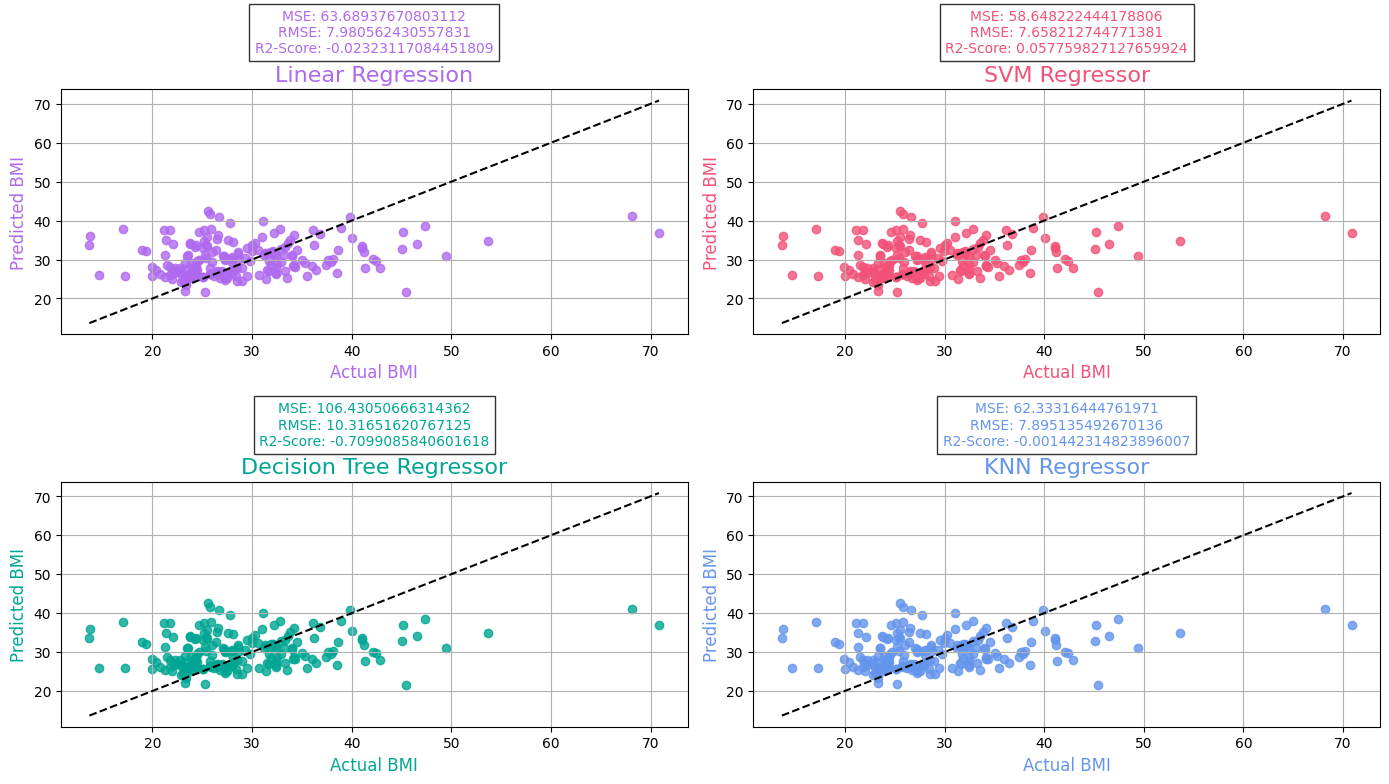

In [84]:

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# linear Regressor
lr = LinearRegression().fit(x_train, y_train)
lr_pred = lr.predict(x_test)
mse_lr, rmse_lr, r2_lr = calculate_metrics('Linear Regression', lr_pred, y_test)
actual_vs_predicted_plot(axs[0, 0], 'Linear Regression', y_test, lr_pred ,mse_lr ,rmse_lr,r2_lr ,color='#AF69EF')

# SVM Regressor
svr = SVR(kernel='linear').fit(x_train, y_train).fit(x_train, y_train)
svr_pred = svr.predict(x_test)
mse_svr, rmse_svr, r2_svr =calculate_metrics('SVR Regression', svr_pred, y_test)
actual_vs_predicted_plot(axs[0, 1], 'SVM Regressor', y_test, lr_pred ,mse_svr, rmse_svr, r2_svr, color='#F25278')


# Decision tree Regressor
dtr = DecisionTreeRegressor(random_state=42).fit(x_train, y_train)
dtr_pred = dtr.predict(x_test)
mse_dtr, rmse_dtr, r2_dtr = calculate_metrics('Decision Tree Regressor', dtr_pred, y_test)
actual_vs_predicted_plot(axs[1, 0], 'Decision Tree Regressor', y_test, lr_pred, mse_dtr, rmse_dtr, r2_dtr, color='#00A693')

# kNN Regressor
knnr = KNeighborsRegressor().fit(x_train, y_train)
knnr_pred = knnr.predict(x_test)
mse_knr, rmse_knr, r2_knr = calculate_metrics('kNN Regression', knnr_pred, y_test)
actual_vs_predicted_plot(axs[1, 1], 'KNN Regressor', y_test, lr_pred, mse_knr, rmse_knr, r2_knr, color='#6495ED')

plt.tight_layout()
plt.show()


# Q2.a
Demonstrate the application of Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction on the dataset

focusing on BMI, Blood sodium, and Blood calcium to visualize the data in a reduced- dimensional space. Compare the visualization results of PCA and t-SNE.

###PCA:###
converts data from high dimensional space to low dimensional
space by selecting the most important attributes that capture
maximum information about the dataset.
###t-SNE:###
a non-linear dimensionality reduction algorithm finds patterns in the data based on the similarity of data points with features It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.
####Work plan:####
1. Dividing the data into features(input attributes) and target(output attributes)
2. Standardize the data and apply PCA and t-SNE
3. Checking PCA Components
4. Plot the components (Visualization)
5. Calculate variance ratio

<ipython-input-85-ee4d90c339a0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.dropna(inplace=True)


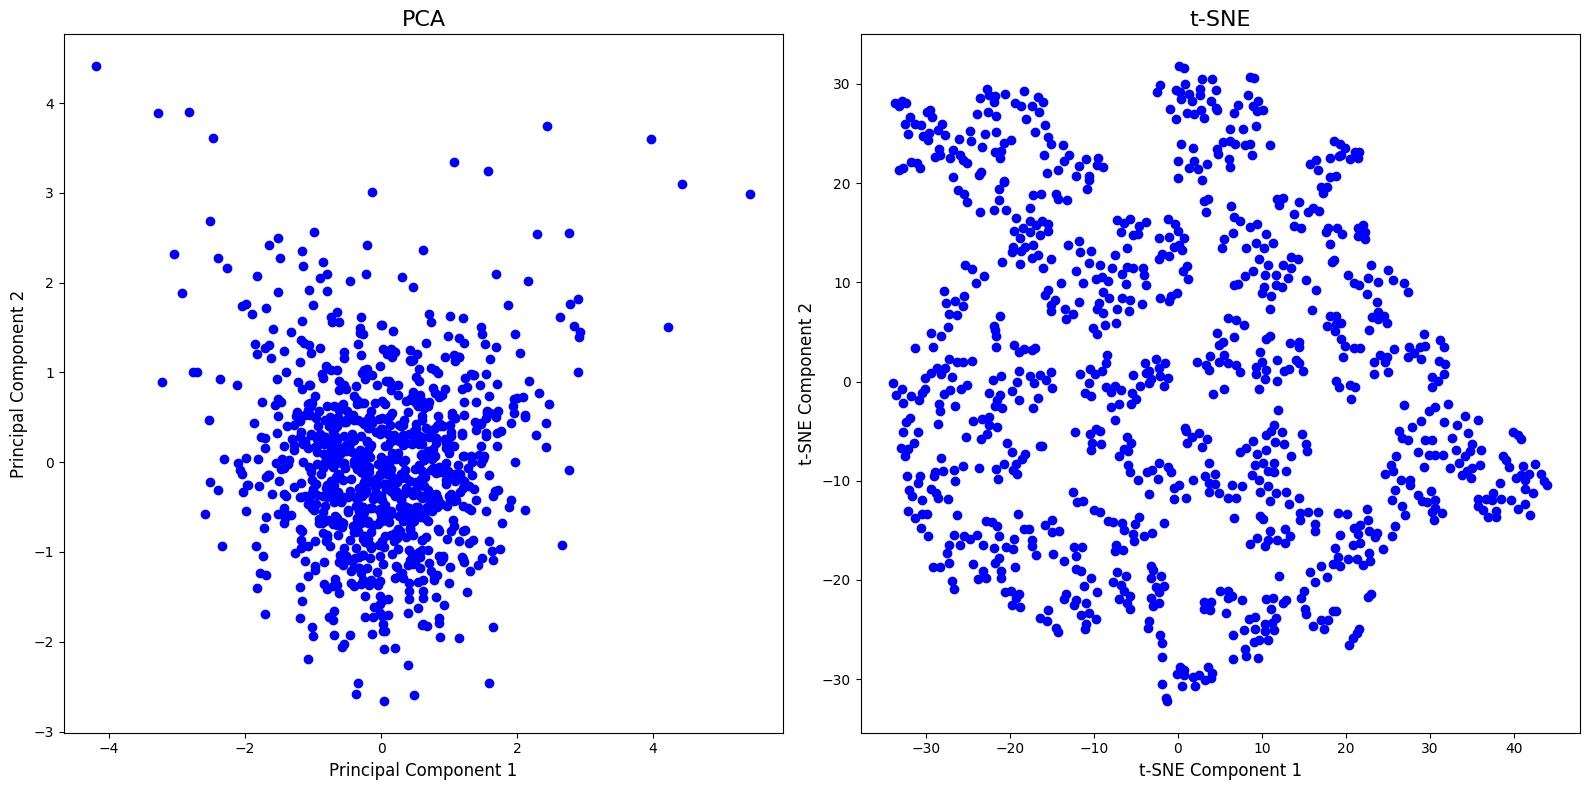

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Selecting specific features for PCA and t-SNE
features = data[['BMI', 'Blood sodium', 'Blood calcium']]

# Drop rows with missing values in the selected columns
features.dropna(inplace=True)
target = data.loc[features.index, 'outcome']  # Keep target aligned with the filtered features

# Print the dimensions
feature_dim = features.shape
"""print(f'The features dimension is: {feature_dim}\n\nThe features are:\n{features}')
print(target.head())"""

# Scale data before applying PCA and t-SNE
scaling = StandardScaler()
Scaled_data = scaling.fit_transform(features)

# Apply PCA with the selected number of components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Scaled_data)

# Apply t-SNE on a subset of the data
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(Scaled_data)

# Creating a new data frame for t-SNE results
tsne_df = pd.DataFrame(data = tsne_result, columns=("Dim_1", "Dim_2"))
tsne_df['Outcome'] = target.values

# Plot the components (Visualization)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the PCA
axs[0].scatter(pca_result[:, 0], pca_result[:, 1], color='blue')
axs[0].set_xlabel('Principal Component 1', fontsize=12)
axs[0].set_ylabel('Principal Component 2', fontsize=12)
axs[0].set_title('PCA', fontsize=16)

# Plot the t-SNE
axs[1].scatter(tsne_df['Dim_1'], tsne_df['Dim_2'], color='blue')
axs[1].set_xlabel('t-SNE Component 1', fontsize=12)
axs[1].set_ylabel('t-SNE Component 2', fontsize=12)
axs[1].set_title('t-SNE', fontsize=16)

plt.tight_layout()
plt.show()

# Q2.b
Apply K-means clustering to the dataset to group patients based on age, BMI, diabetes, and heart rate. Cluster to 2,3,4,5, and 6 groups. What are Silhouette and Davies-Bouldin Score for each case?

In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [87]:
features = ["age", "BMI", "diabetes", "heart rate"]

x = data[features]

# Handling missing values by imputing or dropping them
x = x.dropna()  # Dropping rows with NaN values

In [88]:
def plot_K_means(ax, model, x, colors):
    """
    Plots the K-Means clustering results.

    Parameters for the function:
      ax: matplotlib axis object
      model: trained KMeans model
      x: input data
      colors: list of colors to use for clusters
    """
    cluster_num = model.n_clusters
    ax.set_title(f'K-Means {cluster_num} Clusters')
    scatter = ax.scatter(x.iloc[:, 0], x.iloc[:, 1], c=[colors[label] for label in model.labels_], s=50, alpha=0.8)
    ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='x', s=200, c='black', label='centroids', linewidths=3)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    plt.colorbar(scatter, ax=ax)


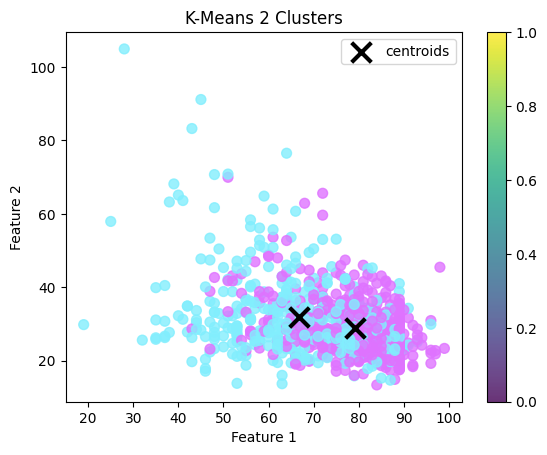

The Cluster number = 2:
The Silhouette Score is: 0.3396542325481858
The Davies-Bouldin Score is: 1.1942302913631218


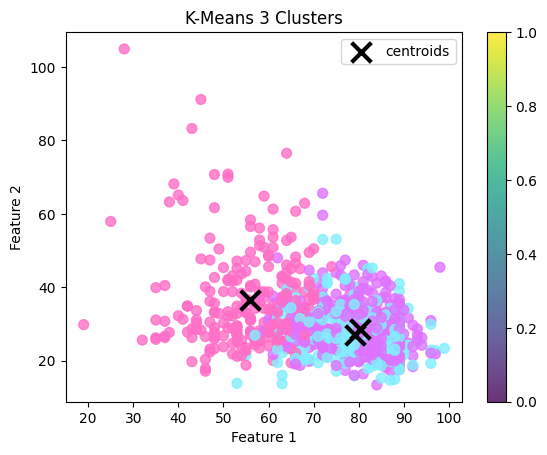

The Cluster number = 3:
The Silhouette Score is: 0.33998182065114374
The Davies-Bouldin Score is: 1.0902915076970932


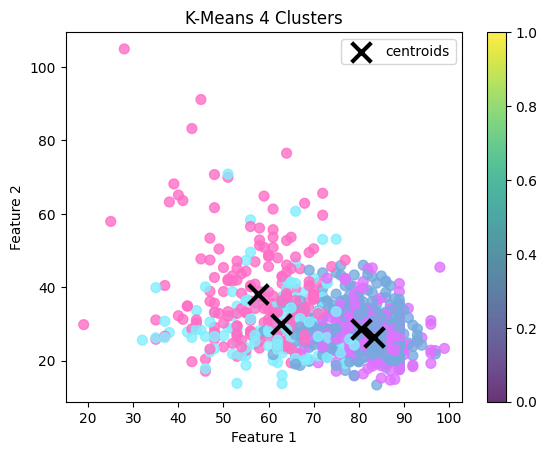

The Cluster number = 4:
The Silhouette Score is: 0.29439149556535005
The Davies-Bouldin Score is: 1.1080554058105856


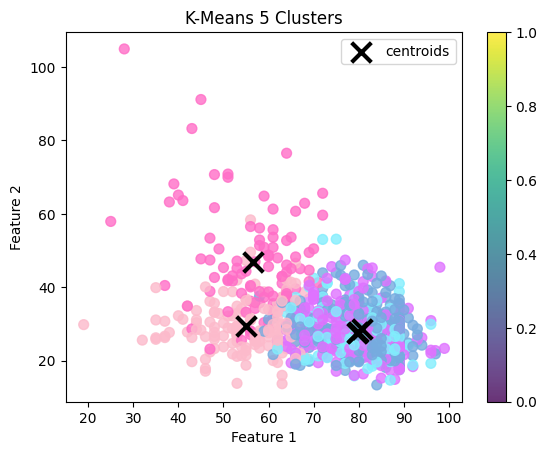

The Cluster number = 5:
The Silhouette Score is: 0.25892977299743686
The Davies-Bouldin Score is: 1.211871042438824


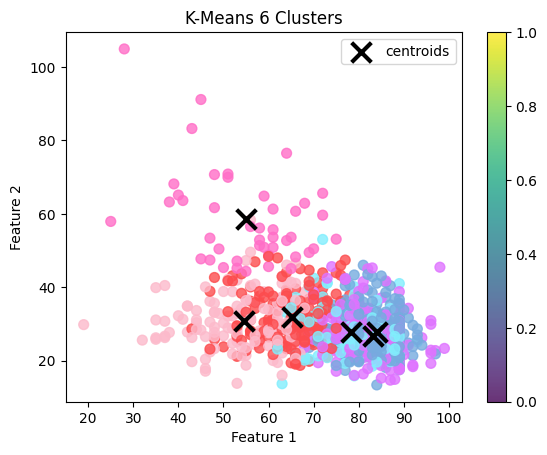

The Cluster number = 6:
The Silhouette Score is: 0.28052169466147786
The Davies-Bouldin Score is: 1.0281092926977888


In [89]:
# Define a list of colors for the clusters
cluster_colors = ['#82EEFD', '#DF73FF','#FF6EC7', '#76ABDF', '#FCBACB', '#FC4C4E']

for n_clusters in [2, 3, 4, 5, 6]:
    k_means = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(x)

    # Plotting the clusters
    fig, ax = plt.subplots()
    plot_K_means(ax, k_means, x, cluster_colors[:n_clusters])
    plt.show()

    # Calculate and print the Silhouette and Davies-Bouldin scores
    silhouette_avg = silhouette_score(x, k_means.labels_)
    davies_bouldin_avg = davies_bouldin_score(x, k_means.labels_)
    print(f'The Cluster number = {n_clusters}:')
    print(f'The Silhouette Score is: {silhouette_avg}')
    print(f'The Davies-Bouldin Score is: {davies_bouldin_avg}')

**Davies-Bouldin Score -**
Measures the average similarity ratio of each cluster with its most similar cluster. A lower score indicates better clustering.

**Meaning of Davies-Bouldin Value > 1**


Davies-Bouldin Value > 1: Indicates poor clustering quality. It suggests that clusters have high similarity to each other, meaning there is significant overlap and high within-cluster variance. In essence, the clusters are not well-separated, implying that the clustering algorithm did not perform well in distinguishing distinct groups in the data.

#Q3.a
Describe the steps involved in training a neural network.

including forward propagation and backpropagation.

## Answer:
### Steps Involved in Training a Neural Network

Training a deep neural network (DNN) involves several key steps: pre-training data processing, architecture choice, forward propagation, loss calculation, and backpropagation.

#### Pre-training Data Processing:
- **Data Collection**: Gather relevant data from various sources.
- **Data Representation**: Decide on the features and their mathematical representation, such as vectors, matrices, or graphs.
- **Data Pre-processing**:
  - **Digitization**: Convert data into mathematical vectors.
  - **Data Cleaning**: Remove outliers, complete missing data, and handle noisy data.
  - **Data Transformation**: Normalize data using methods like min-max normalization or z-score normalization.
  - **Data Integration**: Combine data from different sources into a unified dataset.
  - **Dimensionality Reduction**: Reduce the number of features to simplify data processing.

#### Architecture Choice (Initialization):
Define the model architecture, including the number and types of layers (e.g., dense, convolutional), and their configurations, such as the number of neurons and activation functions.

#### Forward Propagation:
- **Input**: The network receives input data as a vector.
- **Neuron Activation**: In each layer, pass weighted sums through an activation function (e.g., ReLU, sigmoid).
- **Intermediate Results**: Repeat this process in each layer until the output layer.
- **Output**: The output layer returns the network's predictions. For example, in TensorFlow, this is handled with `model.predict(X)`.

#### Loss Calculation:
Define a loss function tailored to the problem and compute the loss by comparing predictions with ground truth. In Keras, this is managed by providing a loss value, such as `model.compile(..., loss="binary_crossentropy")`.

#### Backpropagation:
- **Error Calculation**: Compare predictions to actual results using a loss function (e.g., Mean Squared Error, Cross-Entropy Loss).
- **Gradient Calculation**: Calculate gradients of the weights for each layer using the chain rule (partial derivatives of the loss with respect to each weight and bias).
- **Weight Update**: Update weights in the direction opposite to the gradients using optimization algorithms like Gradient Descent or Adam: **weight=weight−η×gradient**
  where η is the learning rate.
- **Iteration**: Repeat forward and backward propagation steps multiple times (epochs) until the network achieves satisfactory performance. This may involve splitting the data into training and validation sets to monitor and prevent overfitting.


# Q3.b
Explain the bias-variance trade-off in neural network performance.

 How does it affect model generalization?

## Answer:

### Bias-Variance Trade-off in Neural Network Performance

The bias-variance trade-off is a key concept in machine learning that balances two sources of error affecting model performance: bias and variance. Understanding this trade-off is essential for building models that generalize well to new, unseen data.

#### Bias
- **Definition**: Error introduced by simplifying a complex real-world problem with a model.
- **High Bias**: Models are too simple, leading to underfitting where the model fails to capture underlying patterns. This results in poor performance on both training and test data.
  - **Example**: A linear regression model trying to fit a nonlinear dataset.

#### Variance
- **Definition**: Error due to the model's sensitivity to small fluctuations in the training data.
- **High Variance**: Models are too complex, capturing noise along with the underlying patterns. This leads to overfitting, where the model performs well on training data but poorly on test data.
  - **Example**: A neural network with too many layers and neurons fitting a small dataset.

#### Bias-Variance Trade-off
- **Trade-off**: Balancing model complexity to minimize total error. Increasing model complexity decreases bias but increases variance, and vice versa.
  - **High Bias, Low Variance**: Simplified models that underfit.
  - **Low Bias, High Variance**: Complex models that overfit.

#### Impact on Model Generalization
- **Generalization**: The model's ability to perform well on new, unseen data. Good generalization means capturing underlying patterns without fitting the noise.
  - **High Bias**: Poor generalization due to underfitting.
  - **High Variance**: Poor generalization due to overfitting.

#### Managing the Trade-off
- **Techniques**:
  - **Cross-Validation**: Estimates model performance and helps select the right complexity.
  - **Regularization**: Adds a penalty for larger coefficients to prevent overfitting (e.g., L2 or L1 regularization).
  - **Pruning**: Reducing the number of neurons or layers in neural networks to balance bias and variance.
  - **Ensemble Methods**: Combining multiple models to reduce variance without significantly increasing bias.

#### Conclusion
Understanding and managing the bias-variance trade-off is crucial for developing neural network models that generalize well. The goal is to minimize both bias and variance, leading to a model that performs well on both training and unseen data. Techniques like cross-validation, regularization, and pruning are used to adjust model complexity appropriately.

# Q3.c
Highlight the importance of:
 * data preprocessing
 * normalization
 * splitting for training effective deep learning models.

## Answer:
### Importance of Data Preprocessing, Normalization, and Splitting for Training Effective Deep Learning Models

#### Data Preprocessing
Data preprocessing ensures that the data is clean, consistent, and suitable for training.
- **Noise Reduction**: Improves accuracy by removing outliers and noise.
- **Handling Missing Values**: Prevents training errors and ensures complete data for learning.
- **Data Transformation**: Converts raw data into usable formats, like encoding categorical variables.

#### Normalization
Normalization scales the data to a specific range, aiding in convergence and stability.
- **Improved Convergence**: Enables faster and more stable optimization.
- **Preventing Dominance**: Ensures no single feature dominates due to its scale.
- **Consistency Across Features**: Leads to better performance and accuracy.

#### Data Splitting
Splitting data into training, validation, and test sets is crucial for evaluation and preventing overfitting.
- **Training Set**: Used for learning model parameters.
- **Validation Set**: Helps tune hyperparameters and improve the model.
- **Test Set**: Provides an unbiased evaluation on unseen data.

#### Conclusion
Effective preprocessing, normalization, and proper data splitting ensure clean, consistent, and scaled data. These steps lead to faster convergence, improved accuracy, and better generalization in deep learning models.

# Q3.d

Train a DNN that classify the outcome based on the age and the blood sodium only.


Relevant library from tensorflow

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

Ensuring data is clean and ready with all features

## d.1


Separate 'age' and 'blood sodium' as features (X) and 'outcome' as the label (y), ensure the data is clean by removing any rows with missing values using dropna(), and use StandardScaler from sklearn.preprocessing to standardize the features, ensuring that our model receives data within a normalized scale

In [91]:
from sklearn.preprocessing import StandardScaler

"""
1. Data Cleaning:
   Dropping rows with missing values ensures that only complete data is used.

2. Feature Selection:
   Extracting 'age' and 'Blood sodium' as features (X) and 'outcome' as the label

3. Data Standardization:
   Using StandardScaler to normalize the features.
"""

# Data Cleaning
data.dropna(subset=['age', 'Blood sodium', 'outcome'], inplace=True)

# Feature Selection
features = ['age', 'Blood sodium']
x = data[features]
label = 'outcome'
y = data[label]

# Data Standardization
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


 ## d.2


 Split the data into 4 sets: X_train, X_test, y_train, y_test. Use train_test_split() where train size is 80%. Keep the random state as 42.

In [92]:
from sklearn.model_selection import train_test_split
"""
 Data Splitting:
   Using train_test_split to create training and testing sets with an 80-20 split.
"""
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)


## d.3


Construct a deep neural network using four dense layers. Configure the first three layers to each include 3 neurons and utilize the ReLU activation function. The final layer should contain a single neuron with a Sigmoid activation function, suitable for our binary classification tasks. Enhance the model's ability to generalize by incorporating two dropout layers with a dropout rate of 0.05, positioned between every two dense layers to reduce overfitting.

In [93]:

# Model Construction
model = keras.models.Sequential([
    keras.layers.Dense(3, activation="relu", input_shape=(x_train.shape[1],), name="inputLayer"),
    keras.layers.Dense(3, activation="relu", name="hiddenLayer_1"),
    keras.layers.Dense(3, activation="relu", name="hiddenLayer_2"),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(3, activation="relu", name="hiddenLayer_3"),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(1, activation="sigmoid", name="outputLayer"),
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## d.4


Compile the neural network specifying binary_crossentropy as the loss function, adam as the optimizer, and accuracy as the performance metric. Train the model using a 20% validation split for 100 epochs to monitor and validate learning progress over time. Afterwards, graph both the training and validation accuracy, as well as the loss per epoch, to visually assess model performance and convergence. Use the provided examples as a guide for plotting

In [94]:
# Plotting functions
def plot_training_validation_Accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

def plot_training_validation_Loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6715 - loss: 0.6876 - val_accuracy: 0.8506 - val_loss: 0.6696
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8678 - loss: 0.6639 - val_accuracy: 0.8831 - val_loss: 0.6446
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8777 - loss: 0.6379 - val_accuracy: 0.8831 - val_loss: 0.6153
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8936 - loss: 0.6115 - val_accuracy: 0.8831 - val_loss: 0.5824
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8884 - loss: 0.5742 - val_accuracy: 0.8831 - val_loss: 0.5481
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9023 - loss: 0.5288 - val_accuracy: 0.8831 - val_loss: 0.5164
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8783 - loss: 0.5147 - val_accuracy: 0.8831 - val_loss: 0.4890
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9127 - loss: 0.4561 - val_accuracy: 0.8831 - 

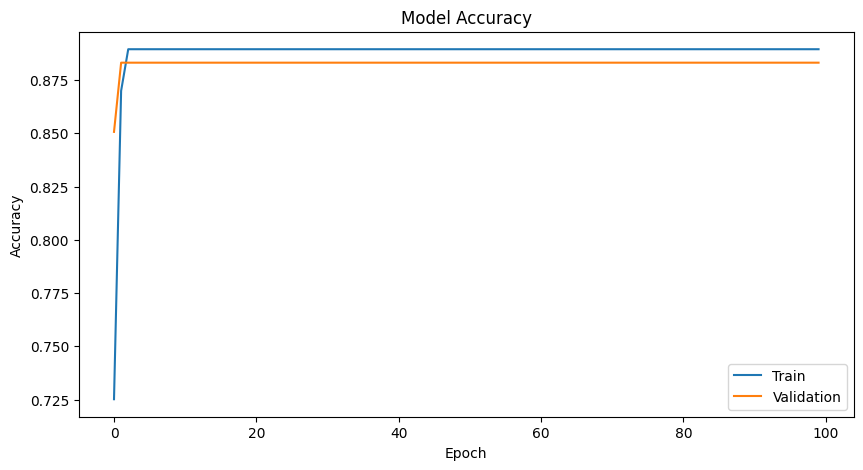

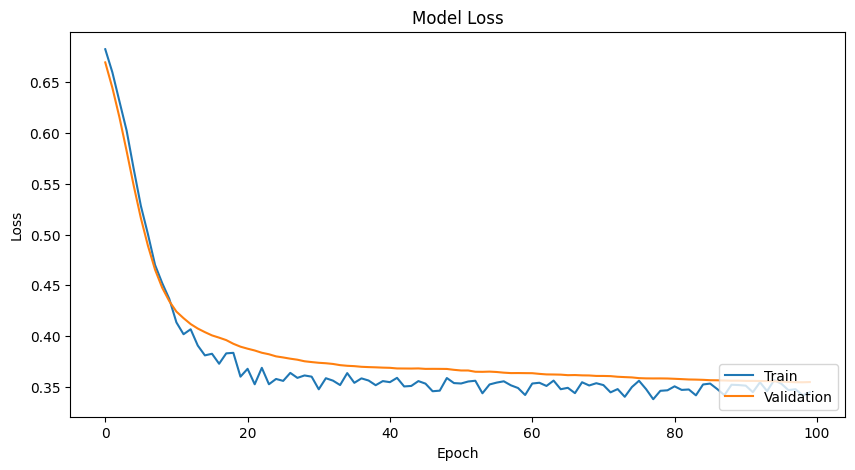

In [95]:
from tensorflow.keras.optimizers import Adam

"""
6. Model Compilation and Training:
   Compile the model with binary_crossentropy loss, adam optimizer, and accuracy metric.
   Train the model using a 20% validation split for 100 epochs.
   Graph training and validation accuracy, as well as loss per epoch.
"""

# Model Compilation and Training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

# Plot graphs
plot_training_validation_Accuracy(history)
plot_training_validation_Loss(history)

## d.5


Evaluate and Visualize Model Performance: Assess the model's accuracy on the test set to gauge its effectiveness in real-world scenarios. Next, visualize the results by plotting a confusion matrix. Additionally, display the model's architecture by invoking model.summary(), which provides a detailed overview of the model layers, their shapes, and the number of parameters involved.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8969 - loss: 0.3317
Test Accuracy: 0.8549
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Accuracy Score: 0.8549


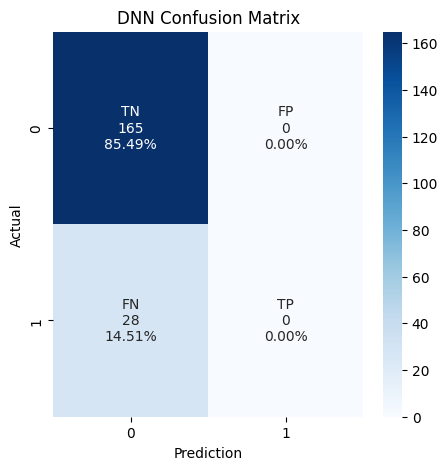

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inputLayer (Dense)                   │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hiddenLayer_1 (Dense)                │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hiddenLayer_2 (Dense)                │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hiddenLayer_3 (Dense)                │ (None, 3)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputLayer (Dense)                  │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149 (600.00 B)

 Trainable params: 49 (196.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 100 (404.00 B)

In [96]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
"""
7. Model Evaluation and Visualization:
   Assess the model's accuracy on the test set.
   Visualize the results with a confusion matrix.
   Display the model's architecture using model.summary().
"""
# Model Evaluation and Visualization
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions on the test set
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Calculate and display the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

# Confusion matrix
plot_confusion_matrix(y_pred, "DNN Confusion Matrix", y_test)

# Model summarization
model.summary()


## d.6


Design a deep neural network model tailored to our predication task of in-hospital mortality. Select relevant features. Your model should include a combination of dense layers and activation functions optimized for binary classification. Try to play with the optimizer, loss, etc.

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.7055 - loss: 1.0163 - val_accuracy: 0.8272 - val_loss: 0.9426
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8543 - loss: 0.8892 - val_accuracy: 0.8272 - val_loss: 0.9073
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8614 - loss: 0.8552 - val_accuracy: 0.8272 - val_loss: 0.8977
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8668 - loss: 0.8318 - val_accuracy: 0.8272 - val_loss: 0.8844
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8576 - loss: 0.7988 - val_accuracy: 0.8272 - val_loss: 0.8778
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8719 - loss: 0.7765 - val_accuracy: 0.8272 - val_loss: 0.8578
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8562 - loss: 0.7578 - val_accuracy: 0.8272 - val_loss: 0.8395
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8450 - loss: 0.7614 - val_accuracy: 0.8272 - val_loss: 0.82

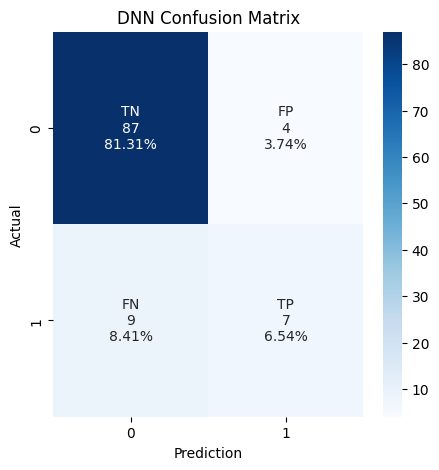

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                     │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 115,397 (450.77 KB)

 Trainable params: 38,465 (150.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,932 (300.52 KB)

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input


# Data Cleaning
data_cleaned = data.dropna()
label = 'outcome'
X = data_cleaned.drop(columns=label)
y = data_cleaned['outcome']

# Data Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split 1: Split into training (75%) and test (25%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Split 2: Split training set into training (75%) and validation (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Model Construction
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32, verbose=1)


# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate and display the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")


# Confusion matrix
plot_confusion_matrix(y_pred, "DNN Confusion Matrix", y_test)

# Model summarization
model.summary()

def print_metrics_object(name, y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name}: {accuracy:.4f}")
